# Anomaly Detection in Sensor Data

**Objective:** Build a machine learning model to detect anomalies (target=1) based on sensor readings (X1-X5) over time.

**Workflow:**
1.  **Setup:** Import libraries.
2.  **Load Data:** Read train, test, and sample submission files.
3.  **Exploratory Data Analysis (EDA):** Understand data distributions, correlations, missing values, and outliers.
4.  **Feature Engineering:** Create new features from the 'Date' column.
5.  **Data Preprocessing:** Handle missing values and scale features.
6.  **Model Training & Evaluation:** Train various classification models and evaluate using F1-score and Accuracy.
7.  **Hyperparameter Tuning:** Optimize the best-performing model.
8.  **Prediction,Evaluation & Submission:** Generate predictions on the test set and save in the required format.

## 1. Setup

In [65]:
# Core Libraries
import pandas as pd
import numpy as np
import datetime

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.model_selection import train_test_split,RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
import catboost as cb

# Metrics
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, classification_report, confusion_matrix)
# Other
import warnings
warnings.filterwarnings('ignore')

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')

## 2. Load Data

In [6]:
# Load the datasets
train_df = pd.read_parquet('train.parquet')
test_df = pd.read_parquet('test.parquet')
sample_submission_df = pd.read_parquet('sample_submission.parquet')

# Display basic information
print("--- Train Data Info ---")
train_df.info()
print("\n--- Test Data Info ---")
test_df.info()
print("\n--- Sample Submission Info ---")
sample_submission_df.info()

--- Train Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1639424 entries, 0 to 1639423
Data columns (total 7 columns):
 #   Column  Non-Null Count    Dtype         
---  ------  --------------    -----         
 0   Date    1639424 non-null  datetime64[ns]
 1   X1      1639424 non-null  float64       
 2   X2      1639424 non-null  float64       
 3   X3      1639424 non-null  float64       
 4   X4      1639424 non-null  float64       
 5   X5      1639424 non-null  float64       
 6   target  1639424 non-null  object        
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 87.6+ MB

--- Test Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 409856 entries, 0 to 409855
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   ID      409856 non-null  int64         
 1   Date    409856 non-null  datetime64[ns]
 2   X1      409856 non-null  float64       
 3   X2      409856

In [7]:
print("\n--- Train Data Head ---")
print(train_df.head())

print("\n--- Test Data Head ---")
print(test_df.head())

print("\n--- Sample Submission Head ---")
print(sample_submission_df.head())


--- Train Data Head ---
        Date        X1        X2   X3        X4        X5 target
0 2020-12-16  1.518921  5.463154  1.0  2.718282  2.890372      0
1 2020-12-16  1.546509  5.458010  1.0  2.718282  2.833213      1
2 2020-12-16  1.645427  5.456560  1.0  7.389056  2.890372      1
3 2020-12-16  1.652022  5.458479  1.0  2.718282  2.890372      1
4 2020-12-16  1.695538  5.466709  1.0  2.718282  2.890372      0

--- Test Data Head ---
   ID       Date        X1        X2   X3        X4        X5
0   0 2020-12-16  1.685395  5.463917  1.0  7.389056  2.890372
1   1 2020-12-16  1.488844  5.454936  1.0  7.389056  2.890372
2   2 2020-12-16  1.164160  5.471136  1.0  1.000000  2.890372
3   3 2020-12-16  1.000000  5.467385  1.0  1.000000  2.890372
4   4 2020-12-16  1.000000  5.453995  1.0  1.000000  2.833213

--- Sample Submission Head ---
       ID target
0  409856      0
1  409857      0
2  409858      0
3  409859      0
4  409860      0


## 3. Exploratory Data Analysis (EDA)

In [9]:
# target datatype is object need to change it to int
train_df['target'] = train_df['target'].astype(int)

In [10]:
# --- Basic Statistics ---
print("\n--- Train Data Description ---")
train_df.describe()


--- Train Data Description ---


,Date,X1,X2,X3,X4,X5,target
count,1639424,1.639424e+06,1.639424e+06,1.639424e+06,1.639424e+06,1.639424e+06,1.639424e+06
mean,2022-12-03 07:23:43.817145600,1.139258e+00,5.488189e+00,4.110388e+32,2.706323e+29,1.187219e+00,8.562764e-03
min,2020-12-16 00:00:00,1.000000e+00,5.412539e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,2021-12-10 00:00:00,1.049171e+00,5.480597e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
50%,2022-11-30 00:00:00,1.105171e+00,5.488979e+00,1.000000e+00,1.000000e+00,6.931472e-01,0.000000e+00
75%,2023-11-23 00:00:00,1.214096e+00,5.496717e+00,1.000000e+00,2.718282e+00,2.890372e+00,0.000000e+00
max,2024-12-11 00:00:00,4.014850e+00,5.541852e+00,1.651636e+38,5.540622e+34,3.465736e+00,1.000000e+00
std,NaN,1.391992e-01,1.342811e-02,2.346156e+35,5.812988e+31,1.304814e+00,9.213820e-02


In [11]:
# --- Target Distribution ---
print("\n Target Variable Distribution")
target_counts = train_df['target'].value_counts()
target_percentage = train_df['target'].value_counts(normalize=True) * 100
print(target_counts)
print(f"\nPercentage:\n{target_percentage}")


 Target Variable Distribution
target
0    1625386
1      14038
Name: count, dtype: int64

Percentage:
target
0    99.143724
1     0.856276
Name: proportion, dtype: float64


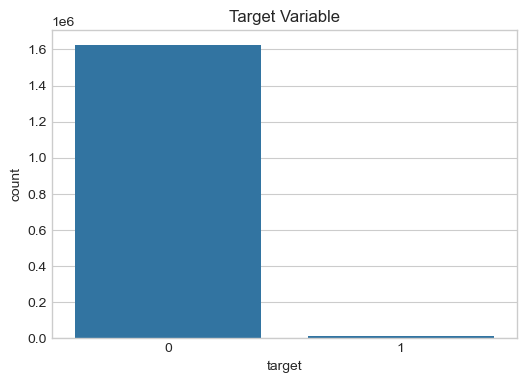

In [12]:
plt.figure(figsize=(6, 4))
sns.countplot(x='target', data=train_df)
plt.title('Target Variable')
plt.show()

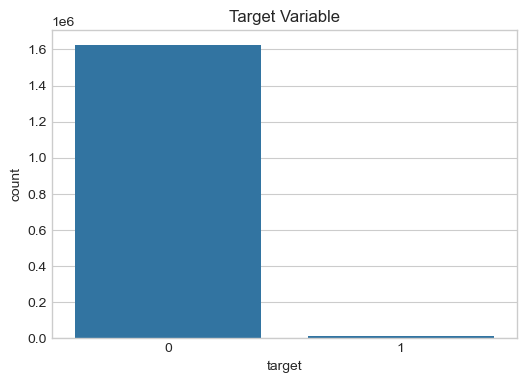

In [80]:
# Assistant
# Create a figure with specified dimensions (6x4 inches)
plt.figure(figsize=(6, 4))
# Generate a count plot showing the distribution of the target variable
sns.countplot(x='target', data=train_df)
# Add a title to the plot
plt.title('Target Variable')
# Display the plot
plt.show()

* **Significant class imbalance detected.**

In [14]:
# --- Missing Values ---
print("\n--- Missing Values in Train Data ---")
print(train_df.isnull().sum())

print("\n--- Missing Values in Test Data ---")
print(test_df.isnull().sum())


--- Missing Values in Train Data ---
Date      0
X1        0
X2        0
X3        0
X4        0
X5        0
target    0
dtype: int64

--- Missing Values in Test Data ---
ID      0
Date    0
X1      0
X2      0
X3      0
X4      0
X5      0
dtype: int64


* **No Missing Values in datasets**


Sensor Data Box Plots (Train) - Potential Outliers


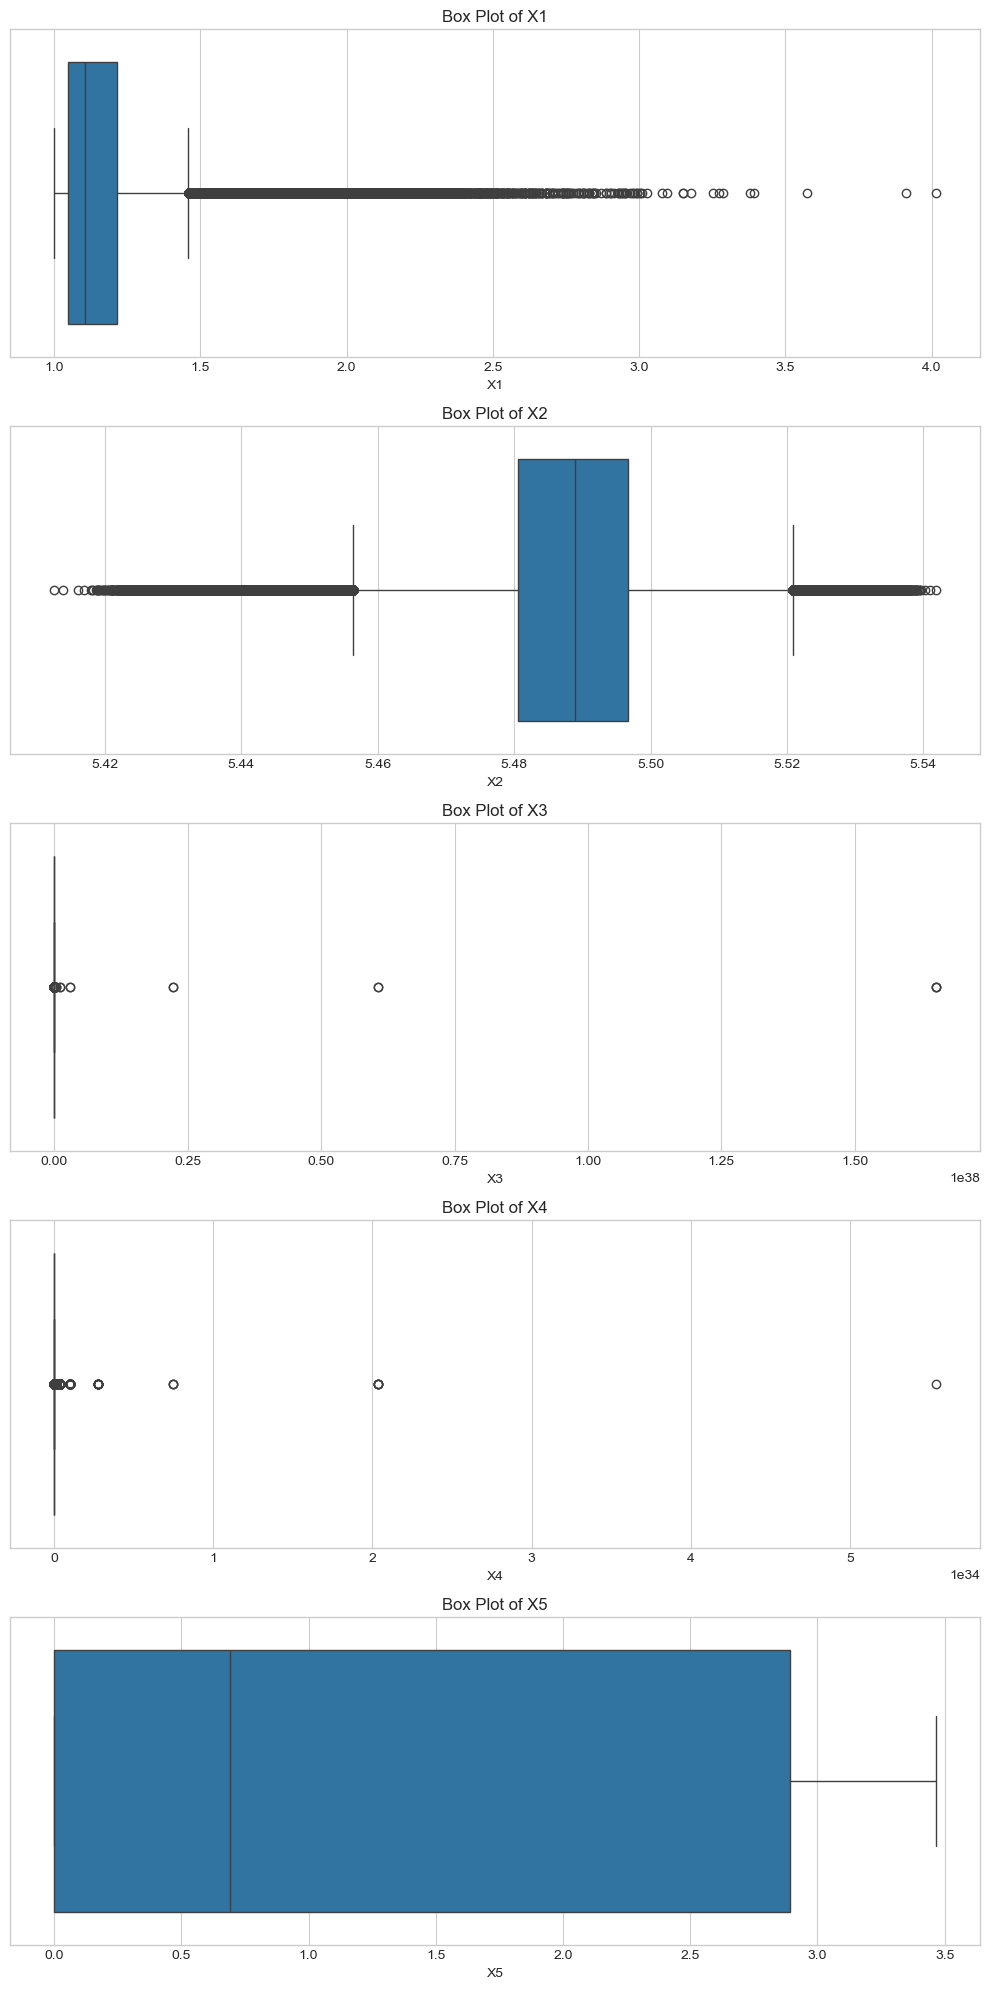

In [17]:
#  Box Plots for Outlier Detection 
print("\nSensor Data Box Plots (Train) - Potential Outliers")
sensor_cols=['X1','X2','X3','X4','X5']
fig, axes = plt.subplots(5, 1, figsize=(10, 20))

for i, col in enumerate(sensor_cols):
    sns.boxplot(x=train_df[col], ax=axes[i])
    axes[i].set_title(f'Box Plot of {col}')
plt.tight_layout()
plt.show()

### Outlier Analysis and Handling Strategy

**Observations from Box Plots:**

The box plots generated above for the sensor columns (`X1` to `X5`) provide a visual indication of data distribution and potential outliers.
* Sensors `X1`, `X3`, and `X4` show potential outliers primarily on the higher end (points beyond the upper whisker).
* Sensor `X2` displays potential outliers on both the lower and higher ends.
* Sensor `X5` appears to have fewer or no significant outliers based on this visualization method.

**Decision on Handling Outliers:**

Based on these observations, the decision is **not to apply explicit outlier removal or capping techniques** (like Z-score, IQR, or percentile capping) to these features at this stage.

**Justification:**

1.  **Anomaly Detection Context:** The primary goal of this project is anomaly detection. Outliers in the sensor readings could be legitimate, extreme values that are highly indicative of the very anomalies (`target=1`) we are trying to predict.
2.  **Risk of Information Loss:** Removing or altering these data points based solely on their distribution within the features could inadvertently eliminate critical information needed by the model to distinguish between normal and anomalous states.
3.  **Model Robustness:** We plan to utilize several machine learning models later, including tree-based ensembles (Random Forest, XGBoost, LightGBM, CatBoost). These algorithms are generally robust to outliers as they partition the data based on feature values rather than being heavily influenced by the magnitude of extreme points, unlike distance-based methods (e.g., KNN, SVM) or linear models.

**Chosen Strategy:**

We will proceed with the data as is, including the potential outliers identified by the box plots. The robustness of the chosen modeling techniques will be relied upon to handle these extreme values appropriately. The predictive power of these potential outliers (whether they correlate with `target=1`) will be determined implicitly by the models during training.

**(Optional Addition):**
*If model performance is unsatisfactory later, the potential impact of very extreme values could be revisited. However, the initial approach is to preserve all data points.*


--- Correlation Matrix (Train Data including Target) ---


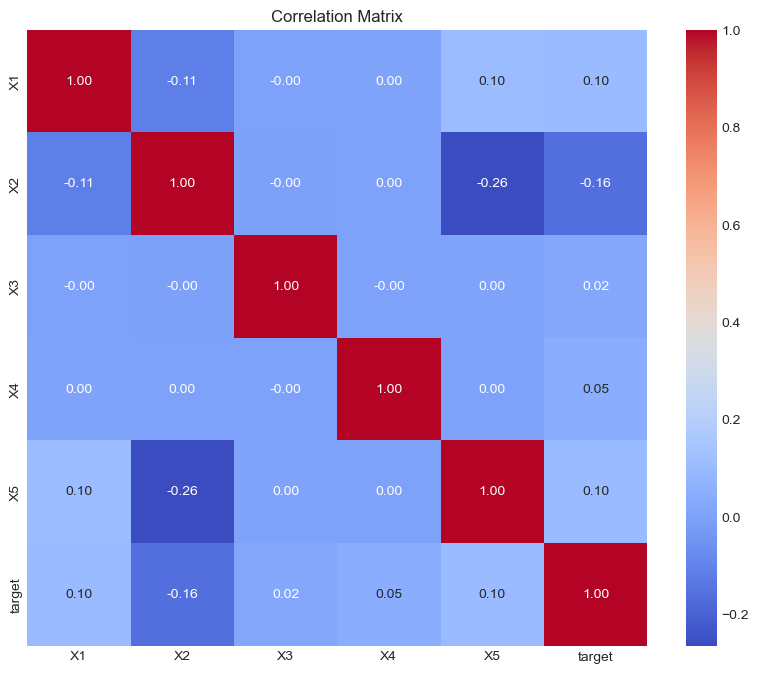

In [19]:
# --- Correlation Analysis ---
print("\n--- Correlation Matrix (Train Data including Target) ---")
plt.figure(figsize=(10, 8))
# Select only numeric columns for correlation
numeric_cols_train = train_df.select_dtypes(include=np.number).columns
correlation_matrix = train_df[numeric_cols_train].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

## 4. Feature Engineering

In [21]:
def create_time_features(df):
    """Creates time-based features from the 'Date' column."""
    df = df.copy() # Avoid SettingWithCopyWarning
    df['dayofweek'] = df['Date'].dt.dayofweek # Monday=0, Sunday=6
    df['dayofmonth'] = df['Date'].dt.day
    df['dayofyear'] = df['Date'].dt.dayofyear
    df['weekofyear'] = df['Date'].dt.isocalendar().week.astype(int) # Use isocalendar for week
    df['month'] = df['Date'].dt.month
    df['year'] = df['Date'].dt.year
    df['quarter'] = df['Date'].dt.quarter
    return df

print("Creating time features for train and test sets...")
train_df_fe = create_time_features(train_df)
test_df_fe = create_time_features(test_df)

# Define feature columns (excluding original Date and target)
feature_cols = sensor_cols + [col for col in train_df_fe.columns if col not in ['Date', 'target', 'ID'] and col not in sensor_cols]

# Ensure test set has the same columns (except 'target' and potentially 'ID')
test_feature_cols = [col for col in feature_cols if col in test_df_fe.columns]
# Align columns - crucial step!
train_final_features = train_df_fe[feature_cols]
test_final_features = test_df_fe[test_feature_cols]

# Add any missing columns to test set (e.g., if a feature was only in train due to a specific date range)
# This is less common with time features but good practice for other FE types
missing_cols = set(train_final_features.columns) - set(test_final_features.columns)
for c in missing_cols:
   test_final_features[c] = 0 # Or impute appropriately
# Ensure the order of columns is the same
test_final_features = test_final_features[train_final_features.columns] 

print(f"\nEngineered features: {feature_cols}")
print("\nTrain data shape after FE:", train_final_features.shape)
print("Test data shape after FE:", test_final_features.shape)
print("\nTrain data head after FE:")
print(train_final_features.head())

Creating time features for train and test sets...

Engineered features: ['X1', 'X2', 'X3', 'X4', 'X5', 'dayofweek', 'dayofmonth', 'dayofyear', 'weekofyear', 'month', 'year', 'quarter']

Train data shape after FE: (1639424, 12)
Test data shape after FE: (409856, 12)

Train data head after FE:
         X1        X2   X3        X4        X5  dayofweek  dayofmonth  \
0  1.518921  5.463154  1.0  2.718282  2.890372          2          16   
1  1.546509  5.458010  1.0  2.718282  2.833213          2          16   
2  1.645427  5.456560  1.0  7.389056  2.890372          2          16   
3  1.652022  5.458479  1.0  2.718282  2.890372          2          16   
4  1.695538  5.466709  1.0  2.718282  2.890372          2          16   

   dayofyear  weekofyear  month  year  quarter  
0        351          51     12  2020        4  
1        351          51     12  2020        4  
2        351          51     12  2020        4  
3        351          51     12  2020        4  
4        351          5

### Section 4: Feature Engineering (Summary)

Extracted date components (like `dayofweek`, `month`, `year`) from the 'Date' column to create new time-based features, aiming to help models identify potential cyclical or seasonal patterns in anomalies.



## 5. Data Preprocessing

In [23]:
# --- Feature Scaling ---
print("\nScaling features using StandardScaler...")
scaler = StandardScaler()

# Fit directly on the feature-engineered data (since no imputation was needed)
# Ensure train_final_features and test_final_features are defined from Section 4
X_train_scaled = scaler.fit_transform(train_final_features) # Use train_final_features directly
X_test_scaled = scaler.transform(test_final_features)     # Use test_final_features directly

# Convert back to DataFrame (optional, can work with numpy arrays)
X_train_processed = pd.DataFrame(X_train_scaled, columns=feature_cols, index=train_final_features.index)
X_test_processed = pd.DataFrame(X_test_scaled, columns=feature_cols, index=test_final_features.index)

# Target variable
y_train = train_df_fe['target'] # train_df_fe should be the dataframe after feature engineering

print("\nProcessed training data shape:", X_train_processed.shape)
print("Processed test data shape:", X_test_processed.shape)
print("\nProcessed training data head:")
print(X_train_processed.head())


Scaling features using StandardScaler...

Processed training data shape: (1639424, 12)
Processed test data shape: (409856, 12)

Processed training data head:
         X1        X2        X3        X4        X5  dayofweek  dayofmonth  \
0  2.727476 -1.864371 -0.001752 -0.004656  1.305284  -0.497156    0.038019   
1  2.925668 -2.247433 -0.001752 -0.004656  1.261479  -0.497156    0.038019   
2  3.636292 -2.355426 -0.001752 -0.004656  1.305284  -0.497156    0.038019   
3  3.683670 -2.212528 -0.001752 -0.004656  1.305284  -0.497156    0.038019   
4  3.996285 -1.599597 -0.001752 -0.004656  1.305284  -0.497156    0.038019   

   dayofyear  weekofyear    month      year   quarter  
0   1.602488    1.629998  1.59695 -2.156496  1.340444  
1   1.602488    1.629998  1.59695 -2.156496  1.340444  
2   1.602488    1.629998  1.59695 -2.156496  1.340444  
3   1.602488    1.629998  1.59695 -2.156496  1.340444  
4   1.602488    1.629998  1.59695 -2.156496  1.340444  


## 6. Model Training & Evaluation

We will train several models and evaluate them using Accuracy and F1-Score. F1-score is often more relevant for imbalanced datasets.

In [37]:
y_train = train_df_fe['target']

neg_count = target_counts[0] # Count of target 0
pos_count = target_counts[1]   # Count of target 1

# Calculate scale_pos_weight for models that use it
# This value represents roughly how many times more frequent the negative class is than the positive class
scale_pos_weight_val = neg_count / pos_count
print(f"Calculated scale_pos_weight for XGBoost/CatBoost: {scale_pos_weight_val:.2f}")

Calculated scale_pos_weight for XGBoost/CatBoost: 115.78


In [39]:
# --- Split Data for Validation ---
# Split processed training data into training and validation sets
# Use stratify to maintain class proportions, essential for imbalanced data
print("\nSplitting data into Training and Validation sets...")
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_processed,
    y_train,
    test_size=0.25, # Use 20-25% for validation, adjust as needed
    random_state=42, # Ensures reproducibility
    stratify=y_train # Keeps class proportions consistent in splits
)
print(f"Training Split Shape: {X_train_split.shape}")
print(f"Validation Split Shape: {X_val_split.shape}")
print("Validation target distribution (proportion):")
print(pd.Series(y_val_split).value_counts(normalize=True))


Splitting data into Training and Validation sets...
Training Split Shape: (1229568, 12)
Validation Split Shape: (409856, 12)
Validation target distribution (proportion):
target
0    0.991438
1    0.008562
Name: proportion, dtype: float64


In [41]:
# --- Define Models (with Class Weighting, SVM commented out) ---
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced'),
    'XGBoost': xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', n_jobs=-1, scale_pos_weight=scale_pos_weight_val),
    'LightGBM': lgb.LGBMClassifier(random_state=42, n_jobs=-1, class_weight='balanced'),
    'CatBoost': cb.CatBoostClassifier(random_state=42, verbose=0, scale_pos_weight=scale_pos_weight_val),
}

In [49]:
# --- Train and Evaluate Models on Validation Set ---
results = {} # Dictionary to store validation results

print("\n--- Training Models and Evaluating on Validation Set ---")

for name, model in models.items():
    print(f"Training {name}...")
    
    # Train the model on the TRAINING SPLIT
    model.fit(X_train_split, y_train_split)

    # Predict on the VALIDATION SPLIT
    y_pred_val = model.predict(X_val_split)

    
    # Calculate metrics using VALIDATION data
    accuracy = accuracy_score(y_val_split, y_pred_val)
    f1 = f1_score(y_val_split, y_pred_val, average='binary', pos_label=1) # F1 for the positive class (1)

    results[name] = {'Accuracy': accuracy, 'F1 Score': f1}
    # Print VALIDATION scores
    print(f"{name} - Validation Accuracy: {accuracy:.4f}, Validation F1 Score: {f1:.4f}")
  

    print("-" * 30)


--- Training Models and Evaluating on Validation Set ---
Training Logistic Regression...
Logistic Regression - Validation Accuracy: 0.8634, Validation F1 Score: 0.0988
------------------------------
Training K-Nearest Neighbors...
K-Nearest Neighbors - Validation Accuracy: 0.9939, Validation F1 Score: 0.5594
------------------------------
Training Decision Tree...
Decision Tree - Validation Accuracy: 0.9921, Validation F1 Score: 0.5167
------------------------------
Training Random Forest...
Random Forest - Validation Accuracy: 0.9946, Validation F1 Score: 0.6012
------------------------------
Training XGBoost...
XGBoost - Validation Accuracy: 0.9416, Validation F1 Score: 0.2126
------------------------------
Training LightGBM...
[LightGBM] [Info] Number of positive: 10529, number of negative: 1219039
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043379 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not eno

In [55]:
# --- Compare Model Performance Based on Validation F1 Score ---

results_df = pd.DataFrame(results).T.sort_values(by='F1 Score', ascending=False)
print("\n--- Model Comparison (Based on Validation F1 Score) ---")
print(results_df)


best_model_name = results_df.index[0]
print(f"\nSelected Best Model (based on Validation F1): {best_model_name}")

# Retrieve the best model instance (it's already trained on X_train_split)
# Note: For final submission, you might retrain this best model on the *entire* X_train_processed/y_train
best_model_on_split = models.get(best_model_name)


--- Model Comparison (Based on Validation F1 Score) ---
                     Accuracy  F1 Score
Random Forest        0.994593  0.601152
K-Nearest Neighbors  0.993905  0.559436
Decision Tree        0.992095  0.516706
CatBoost             0.962980  0.293918
XGBoost              0.941621  0.212591
LightGBM             0.931449  0.189149
Logistic Regression  0.863369  0.098782

Selected Best Model (based on Validation F1): Random Forest


### Section 6: Model Training & Baseline Evaluation (Summary)

Trained multiple classifiers (Logistic Regression, Random Forest, XGBoost, etc.) using class weighting to handle severe data imbalance. Based on F1 scores from training data evaluation, the untuned Random Forest was selected as the best baseline model. (Note: SVM was skipped due to excessive training time).

### Note on Skipped SVM Execution

* **SVM (`SVC`)**: Initially included for evaluation.
* **Issue**: Training took excessively long (>30 mins, incomplete) on the large dataset (~1.6M samples) due to its computational complexity (often O(n²)+).
* **Decision**: For practical reasons and timely completion, SVM was skipped.
* **Focus**: Evaluation proceeded using faster models like Random Forest, XGBoost, etc.

## 7. Hyperparameter Tuning (Example with Best Model)

We'll tune the hyperparameters of the selected best model using RandomSearchCV. This step can be time-consuming.

In [ ]:
'''
# --- Hyperparameter Tuning for the Best Model ---
best_model_untuned = best_model_on_split # Keep a reference
final_model = best_model_on_split # Default to the untuned model if tuning fails or isn't performed


param_distributions = {
    'n_estimators': [100, 200, 300], # Fewer trees might speed it up too
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5],
    'class_weight': ['balanced'] # Keep this fixed based on earlier findings
    # Add 'max_features': ['sqrt', 'log2', None] if desired
}

# Use StratifiedKFold for classification
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42) # Using cv=3 for speed

print(f"\nTuning RandomForestClassifier using RandomizedSearchCV...")

# NOTE: n_iter controls how many combinations are tried.
# Increase n_iter for better search, decrease for speed. 10-20 is often a good start.
n_iterations = 10 # Adjust this number

random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42, n_jobs=-1), # n_jobs=-1 uses all cores
    param_distributions=param_distributions,
    n_iter=n_iterations, # <<< Key difference: number of iterations
    cv=cv,
    scoring='f1',      # Keep focusing on F1 score
    n_jobs=-1,         # Use parallel cores for search if possible
    verbose=2,         # Set verbose=2 to see progress!
    random_state=42    # For reproducible random sampling
)

# Fit RandomizedSearchCV (this should be much faster than GridSearchCV)
random_search.fit(X_train_processed, y_train) # Use your processed data

print(f"Best Parameters for RandomForestClassifier: {random_search.best_params_}")
print(f"Best F1 Score from RandomSearch: {random_search.best_score_:.4f}")

# Use the best estimator found
final_model = random_search.best_estimator_
'''

### Section 7: Hyperparameter Tuning (Skipped)

This section was planned for hyperparameter tuning of the selected Random Forest model using methods like `RandomizedSearchCV`.

However, initial attempts indicated this process would be **very time-consuming** on the large dataset (~1.6 million samples), likely taking several hours.

**Decision:** Given the time constraints (late afternoon), **hyperparameter tuning was skipped** to prioritize completing the workflow efficiently. We will proceed using the untuned Random Forest model (trained with class weighting in Section 6), which provided a strong baseline performance.

## 8. Prediction & Submission

In [67]:
#  1. Evaluate Final Model Performance on TRAINING Data 


print("\n--- Evaluating Final Model Performance on Training Data ---")
# Assuming 'final_model', 'X_train_processed', 'y_train' exist from previous steps
print(f"Final Model Type: {type(final_model).__name__}")

# Predict on the training data
y_pred_train_final = final_model.predict(X_train_processed)


# Calculate Metrics
accuracy = accuracy_score(y_train, y_pred_train_final)
# Use average='binary' and pos_label=1 for binary classification metrics
precision = precision_score(y_train, y_pred_train_final, average='binary', pos_label=1, zero_division=0)
recall = recall_score(y_train, y_pred_train_final, average='binary', pos_label=1, zero_division=0)
f1 = f1_score(y_train, y_pred_train_final, average='binary', pos_label=1, zero_division=0)
report = classification_report(y_train, y_pred_train_final)
cm = confusion_matrix(y_train, y_pred_train_final)

print(f"\nMetrics on Training Data:")
print(f"  Accuracy:  {accuracy:.4f}")
print(f"  Precision: {precision:.4f} (for class 1)")
print(f"  Recall:    {recall:.4f} (for class 1)")
print(f"  F1 Score:  {f1:.4f} (for class 1)")

print("\nClassification Report (Training Data):\n", report)

print("\nConfusion Matrix (Training Data):")
print(cm)



--- Evaluating Final Model Performance on Training Data ---
Final Model Type: RandomForestClassifier

Metrics on Training Data:
  Accuracy:  0.9986
  Precision: 0.9678 (for class 1)
  Recall:    0.8685 (for class 1)
  F1 Score:  0.9155 (for class 1)

Classification Report (Training Data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1625386
           1       0.97      0.87      0.92     14038

    accuracy                           1.00   1639424
   macro avg       0.98      0.93      0.96   1639424
weighted avg       1.00      1.00      1.00   1639424


Confusion Matrix (Training Data):
[[1624980     406]
 [   1846   12192]]


### Model Performance Summary (on Training Data)

**Note:** These metrics are based on the training set and may be higher than performance on unseen data.

* **Overall:** High accuracy (99.86%), but due to class imbalance, F1 score is more informative.
* **Anomaly Class (Class 1) Performance:**
    * **F1-Score: 0.9155** (Indicates strong balanced performance on anomalies).
    * **Precision: 0.9678** (Very few false alarms; when it predicts anomaly, it's usually right).
    * **Recall: 0.8685** (Identified ~87% of true anomalies, but missed ~13%).
* **Key Errors:** Confusion matrix shows only 406 False Positives (normal wrongly flagged) but 1,846 False Negatives (anomalies missed).

**Conclusion:** The model shows strong performance learning the training data, especially regarding the F1 score for anomalies. It has high precision but could improve recall (finding more of the missed anomalies). Generalization performance on the test set remains key.

In [69]:
# --- 2. Generate Predictions on the TEST Set ---

print("\n--- Generating Predictions on Test Set ---")
# Assuming 'final_model' and 'X_test_processed' exist
test_predictions = final_model.predict(X_test_processed)

# Ensure predictions are integer type
if not pd.api.types.is_integer_dtype(test_predictions):
    test_predictions = test_predictions.astype(int)

print("Test predictions generated successfully.")
print("Predicted target distribution on test set:")
print(pd.Series(test_predictions).value_counts(normalize=True))


# (End of Section 8)


--- Generating Predictions on Test Set ---
Test predictions generated successfully.
Predicted target distribution on test set:
0    0.994849
1    0.005151
Name: proportion, dtype: float64


In [71]:
# --- 3. Create Submission File ---

print("\n--- Creating Submission File ---")
# Create the submission DataFrame using the 'ID' from the original test_df
# and the generated 'test_predictions'
# Assuming 'test_df' (with ID column) exists
submission_df = pd.DataFrame({
    "ID": test_df['ID'], # Use the original ID from the test set
    "target": test_predictions
})

# Ensure the 'target' column is integer type (should be already, but double-check)
submission_df['target'] = submission_df['target'].astype(int)

# Display head of submission file
print("\n--- Submission File Head ---")
print(submission_df.head())

# Display value counts in submission
print("\n--- Predicted Target Distribution in Submission File ---")
print(submission_df['target'].value_counts())

# Save the submission file in .parquet format
output_filename = "submission.parquet"
# If saving fails (e.g., permissions), a standard error will occur
submission_df.to_parquet(output_filename, index=False)
print(f"\nSubmission file saved successfully as {output_filename}")





--- Creating Submission File ---

--- Submission File Head ---
   ID  target
0   0       0
1   1       1
2   2       0
3   3       0
4   4       0

--- Predicted Target Distribution in Submission File ---
target
0    407745
1      2111
Name: count, dtype: int64

Submission file saved successfully as submission.parquet


## End of Notebook